# コサイン類似度によるムービーレコメンデーション学習用

レコメンデーションシステムは、ユーザーに「関連性のある」提案を提供する機械学習アルゴリズムの重要なクラスです。Youtube、Amazon、Netflix などは、すべてレコメンデーションシステムで機能しており、システムがあなたの過去の活動に基づいて（コンテンツベースのフィルタリング）、またはあなたと似たような他のユーザーの活動や好みに基づいて、次のビデオや商品を推薦してくれます（コラボレーションフィルタリング）。同様に、 Facebook もレコメンデーションシステムを利用して、オフラインで知り合いの Facebook ユーザーを推薦しています。

レコメンデーションシステムは、コンテンツまたはコンテンツにアクセスしたユーザー間の類似性に基づいて機能します。
2つのアイテム間の類似性を測定する方法はいくつかあります。レコメンデーションシステムは、この類似度マトリックスを使用して、次に最も類似した商品をユーザーに推薦します。
このノートブックでは、ユーザーが好きな映画に基づいて映画を推薦する機械学習アルゴリズムを構築します。この機械学習モデルはコサイン類似度に基づいています。

## より大規模なレコメンデーションシステムの構築は以下を参照してください

- [Light FM 近似最近傍探索](02_ANN_annoy_nsmlib_example.ipynb)
- [Light FM Hybrid matrix factorisation model](https://github.com/microsoft/recommenders/blob/master/examples/02_model_hybrid/lightfm_deep_dive.ipynb)

## Setup

映画レコメンドシステムを構築するための最初のステップは、適切なデータを得ることです。映画のデータセットはウェブからダウンロードするか、以下のリンクから "movie_dataset.csv "というタイトルの 22MB の CSV ファイルをダウンロードすることができます。

インデックス、予算、ジャンル、ホームページ、ID、キーワード、オリジナル言語、オリジナルタイトル、概要、人気、制作会社、制作国、公開日、収益、ランタイム、音声言語、ステータス、キャッチフレーズ、タイトル、投票数、投票数、キャスト、スタッフ、監督の 24 カラムの合計 4802 本の映画が CSV ファイルに含まれています。

In [149]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv(r"movie_dataset.csv")

df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


## Features List

使用する特徴量のリストを作成します。前述したように、我々の問題を考慮して、最も関連性の高い特徴量のみを使用します。したがって、私たちが選んだ特徴量は、キーワード、キャスト、ジャンル、監督になります。

ホラー映画が好きなユーザーは、ほとんどの場合、別のホラー映画を好きになるでしょう。あるユーザーは、自分の好きな俳優が出演している映画を見るのが好きなのかもしれません。また、特定の人物が監督した映画が好きな人もいるでしょう。これらすべての要素を組み合わせることで、私たちの推薦アルゴリズムを訓練するのに十分な 4 つの特徴が得られます。


さらに、少しだけデータの前処理を行い、NaN 値を持つ行をスペース/空の文字列に置き換えることで、コードを実行している間にエラーが発生しないようにします。この前処理は for ループで行っています。

In [150]:
features = ['keywords', 'cast', 'genres', 'director']
for feature in features:
    df[feature] = df[feature].fillna('')
    
df[feature]

0           James Cameron
1          Gore Verbinski
2              Sam Mendes
3       Christopher Nolan
4          Andrew Stanton
              ...        
4798     Robert Rodriguez
4799         Edward Burns
4800          Scott Smith
4801          Daniel Hsia
4802     Brian Herzlinger
Name: director, Length: 4803, dtype: object

## Combining Relevant Features into a Single Feature

次に、 combined_features という関数を定義します。この関数は、便利な機能（キーワード、キャスト、ジャンル、監督）をそれぞれの行から結合し、結合された特徴量を1つの文字列にまとめた行を返します。

既存のデータフレーム(df)に新しい列、combined_featuresを追加し、各行(axis = 1)に上記の関数を適用します。これで、データフレームの最後に余分な列が追加され、結合された特徴の行で構成されるようになります。

In [151]:
def combined_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']

df["combined_features"] = df.apply(combined_features, axis =1)

df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,combined_features
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,culture clash future space war space colony so...
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,ocean drug abuse exotic island east india trad...
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,spy based on novel secret agent sequel mi6 Dan...
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan,dc comics crime fighter terrorist secret ident...
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton,based on novel mars medallion space travel pri...


## Extracting Features

[sklearn.feature_extraction](https://scikit-learn.org/stable/modules/feature_extraction.html) モジュールは、テキストや画像などの形式からなるデータセットから、機械学習アルゴリズムでサポートされている形式の特徴量を抽出するために利用できます。今回は CountVectorizer の fit.tranform を使ってテキストの数をカウントし、変換した行列 count_matrix を配列に出力して理解を深めていきます。

In [152]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["combined_features"])

print(type(count_matrix))

print("Count Matrix:", count_matrix.toarray())

<class 'scipy.sparse.csr.csr_matrix'>
Count Matrix: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [153]:
#mtx.size - 非ゼロの数 ( self.getnnz() と同じ)
print(count_matrix.size)

#mtx.shape - 行と列の数 (タプル)
print(count_matrix.shape)

#dataには行方向に非ゼロ要素の値が格納される。（dataのサイズは非ゼロ要素の数）
print(count_matrix.data)
# [10 20 30 40 50]

#indices[j]はdata[j]が何列目の要素かを示す。（indicesのサイズはdataのサイズに等しい）
print(count_matrix.indices)
# [1 2 0 2 2]

#indptrはdataおよびindicesにおいて、どこからどこまでが同じ行かを示す。（indptrのサイズは行列の行数+1）
print(count_matrix.indptr)
# [0 2 4 5]

97547
(4803, 14845)
[1 1 1 ... 1 1 2]
[3115 2616 4886 ... 3093 4502 5900]
[    0    24    54 ... 97520 97531 97547]


## Using the Cosine Similarity

ここでは、2つの映画の類似度を計算するための指標として、Sklearnのコサイン類似度を使います。

コサイン類似度は、2つの項目がどれだけ似ているかを測定するために使われるメトリックです。数学的には、多次元空間に投影された2つのベクトル間の角度の余弦を測定します。出力値の範囲は 0-1 です。

0は類似性がないことを意味し、1は両方の項目が100%類似していることを意味します。

python の Cosine Similarity または cosine カーネルは，入力サンプル X と Y の正規化されたドット積として類似度を計算します．

In [154]:
cosine_sim = cosine_similarity(count_matrix)

print(type(cosine_sim), cosine_sim.shape)
#4803x4803

np.set_printoptions(threshold=np.inf)
print(cosine_sim[0])

<class 'numpy.ndarray'> (4803, 4803)
[1.         0.10540926 0.12038585 0.03774257 0.23094011 0.19245009
 0.         0.14054567 0.08206099 0.11785113 0.23094011 0.07698004
 0.12038585 0.11547005 0.18184824 0.07548514 0.13826023 0.12309149
 0.14054567 0.12309149 0.11785113 0.07856742 0.08830216 0.12909944
 0.06804138 0.0860663  0.21821789 0.15713484 0.15713484 0.12309149
 0.18871284 0.19245009 0.10910895 0.14547859 0.         0.16798421
 0.15713484 0.21516574 0.1132277  0.15097027 0.03573708 0.15097027
 0.         0.19245009 0.16798421 0.15097027 0.21442251 0.34426519
 0.0860663  0.         0.11547005 0.14547859 0.16412199 0.08206099
 0.04012862 0.08206099 0.33596842 0.         0.04536092 0.14814815
 0.         0.27498597 0.08206099 0.07407407 0.1132277  0.03774257
 0.03513642 0.12598816 0.15396007 0.03928371 0.15097027 0.1490712
 0.18518519 0.03573708 0.16412199 0.0860663  0.20064309 0.
 0.08025724 0.14547859 0.12598816 0.16502459 0.16051447 0.18144368
 0.11111111 0.20515248 0.12598816 

cosine_sim 行列は、各映画間のコサイン類似度を計算した numpy 配列です。

上の表を見るとわかるように、映画 0 と映画 0 のコサイン類似度は 1 で、100% 似ています。

同様に、映画0と映画1のコサイン類似度は0.105409です（映画1と映画0のスコアは同じです - 順番は関係ありません）。

映画0と映画4は、映画0と映画3よりも互いに似ています(類似度スコアは0.23094) (スコア=0.0377426)。

1が付いている対角線は、どのような場合かを示唆しており、各映画「x」はそれ自身に100％類似しています!


## Content User likes

次のステップでは、変数 movie_user_likes にユーザーが好きな映画を入力として取ります。
コンテンツベースのフィルタリングシステムを構築しているので、似たようなアイテムを予測するためには、ユーザーの好みを知る必要があります。

In [155]:
movie_user_likes = "Pirates of the Caribbean: The Curse of the Black Pearl"

def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_index = get_index_from_title(movie_user_likes)

movie_index

199

## Generating the Similar Movies Matrix

次に、類似した映画のリストを生成します。入力movie_user_likesとして与えた映画のmovie_indexを使用します。enumerate() メソッドは、反復可能なリスト cosine_sim にカウンタを追加し、各インデックスの類似度スコアを持つ similar_movies のリストの形で返します。

In [156]:
similar_movies = list(enumerate(cosine_sim[movie_index]))

print(len(similar_movies))

similar_movies

4803


[(0, 0.11547005383792516),
 (1, 0.6207522318391884),
 (2, 0.08340576562282992),
 (3, 0.03922322702763681),
 (4, 0.08000000000000002),
 (5, 0.12000000000000002),
 (6, 0.0),
 (7, 0.07302967433402215),
 (8, 0.08528028654224418),
 (9, 0.12247448713915893),
 (10, 0.12000000000000002),
 (11, 0.08000000000000002),
 (12, 0.5421374765483946),
 (13, 0.24000000000000005),
 (14, 0.11338934190276817),
 (15, 0.07844645405527362),
 (16, 0.07184212081070997),
 (17, 0.2984810028978546),
 (18, 0.03651483716701107),
 (19, 0.12792042981336627),
 (20, 0.12247448713915893),
 (21, 0.08164965809277262),
 (22, 0.0917662935482247),
 (23, 0.08944271909999159),
 (24, 0.10606601717798213),
 (25, 0.0),
 (26, 0.07559289460184544),
 (27, 0.08164965809277262),
 (28, 0.12247448713915893),
 (29, 0.08528028654224418),
 (30, 0.11766968108291043),
 (31, 0.08000000000000002),
 (32, 0.1889822365046136),
 (33, 0.07559289460184544),
 (34, 0.0),
 (35, 0.08728715609439697),
 (36, 0.12247448713915893),
 (37, 0.08944271909999159),

### Sorting the Similar Movies List in Descending Order
次のステップは、リスト similar_movies で映画を並べ替えることです。我々 は、降順でリストをしたいので、我々 は、パラメータ reverse=True を使用しています。

In [157]:
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)


sorted_similar_movies

[(199, 1.0000000000000007),
 (1, 0.6207522318391884),
 (12, 0.5421374765483946),
 (17, 0.2984810028978546),
 (13, 0.24000000000000005),
 (178, 0.21320071635561044),
 (262, 0.21320071635561044),
 (329, 0.20412414523193156),
 (330, 0.20412414523193156),
 (618, 0.20412414523193156),
 (1139, 0.20412414523193156),
 (32, 0.1889822365046136),
 (340, 0.17888543819998318),
 (1658, 0.17888543819998318),
 (92, 0.17457431218879393),
 (2100, 0.17457431218879393),
 (791, 0.17056057308448835),
 (508, 0.16681153124565984),
 (1331, 0.16681153124565984),
 (3385, 0.16681153124565984),
 (187, 0.16329931618554525),
 (334, 0.16329931618554525),
 (389, 0.16329931618554525),
 (267, 0.16000000000000003),
 (1290, 0.16000000000000003),
 (3351, 0.15689290811054724),
 (71, 0.15491933384829668),
 (1701, 0.15491933384829668),
 (117, 0.15396007178390023),
 (292, 0.15118578920369088),
 (1932, 0.15118578920369088),
 (536, 0.1485562705416415),
 (2953, 0.1485562705416415),
 (1183, 0.1455213750217998),
 (715, 0.1414213562

sorted_similar_movies は、入力映画 movie_user_likes との類似度スコアを基準にして降順に並べ替えられたすべての映画のリストになります。

上記のように、類似度スコアが 1.0000000000000007 の最も類似したものが一番上にあり、そのインデックス番号は 199 です (この映画は入力として与えた 'Pirates of the Caribbean: The Curse of the Black Pearl' で、意味がありますよね？)。

## Printing the Similar Movies

さて、ここでプロジェクトの最後の部分が来ています。これは movie_user_likes 変数を通してシステムに入力として与えたものに似た映画の名前を表示することです。

sorted_similar_movies リストで見られるように、ムービーはインデックス番号でソートされます。インデックス番号を印刷しても何の役にも立たないので、データフレームのようにインデックス番号を取ってムービーのタイトルに隠蔽する単純な関数を定義します。

In [158]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
i=0
for movie in sorted_similar_movies:
    print(get_title_from_index(movie[0]))
    i=i+1
    if i>15:
        break

Pirates of the Caribbean: The Curse of the Black Pearl
Pirates of the Caribbean: At World's End
Pirates of the Caribbean: Dead Man's Chest
Pirates of the Caribbean: On Stranger Tides
The Lone Ranger
Rango
The Lord of the Rings: The Fellowship of the Ring
The Lord of the Rings: The Return of the King
The Lord of the Rings: The Two Towers
Mystery Men
The Warrior's Way
Alice in Wonderland
Cutthroat Island
The Imaginarium of Doctor Parnassus
How to Train Your Dragon
Mortal Kombat


いよいよアプリケーションの登場です。上記の手順で独自のレコメンドシステムをコーディングし、movie_user_likesに好きな映画を与えてコードを実行します。

私は "Pirates of the Caribbean: The Curse of the Black Pearl" を与えましたが、上記のような類似した映画を表示してくれます。

### 以下の movie_user_likes に映画のタイトルを入れて類似性を試してみてください

In [159]:
movie_user_likes = "Commando"

movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)
i=0
for movie in sorted_similar_movies:
    print(get_title_from_index(movie[0]))
    i=i+1
    if i>15:
        break


Commando
True Lies
The Expendables 3
Conan the Destroyer
Eraser
Daylight
The Yards
Terminator 2: Judgment Day
Mad Max 2: The Road Warrior
Wicked Blood
Conan the Barbarian
The Terminator
The Expendables 2
Predator
Tracker
Shaft


In [164]:
movie_user_likes = "Star Wars: Episode III - Revenge of the Sith"

movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)
i=0
for movie in sorted_similar_movies:
    print(get_title_from_index(movie[0]))
    i=i+1
    if i>15:
        break

Star Wars: Episode III - Revenge of the Sith
Star Wars: Episode II - Attack of the Clones
Star Wars: Episode I - The Phantom Menace
Star Wars
The Helix... Loaded
Jumper
Jane Got a Gun
Captain America: The Winter Soldier
Mad Max
The Island
Journey to Saturn
Star Trek Beyond
Star Trek III: The Search for Spock
Mad Max Beyond Thunderdome
Death Race
The Fifth Element


## ベクトルの可視化

ここで、t-SNEアルゴリズムを使用して、多次元空間から2次元空間への埋め込みを視覚化します。t-SNEは、高次元のベクトル空間から低次元の空間へのマッピングを学習するため、次元削減に使用されます。2つの映画のベクトル `u` と `v` が互いに近い場合、低次元の空間でのそれぞれのマッピングも互いに近くなります。

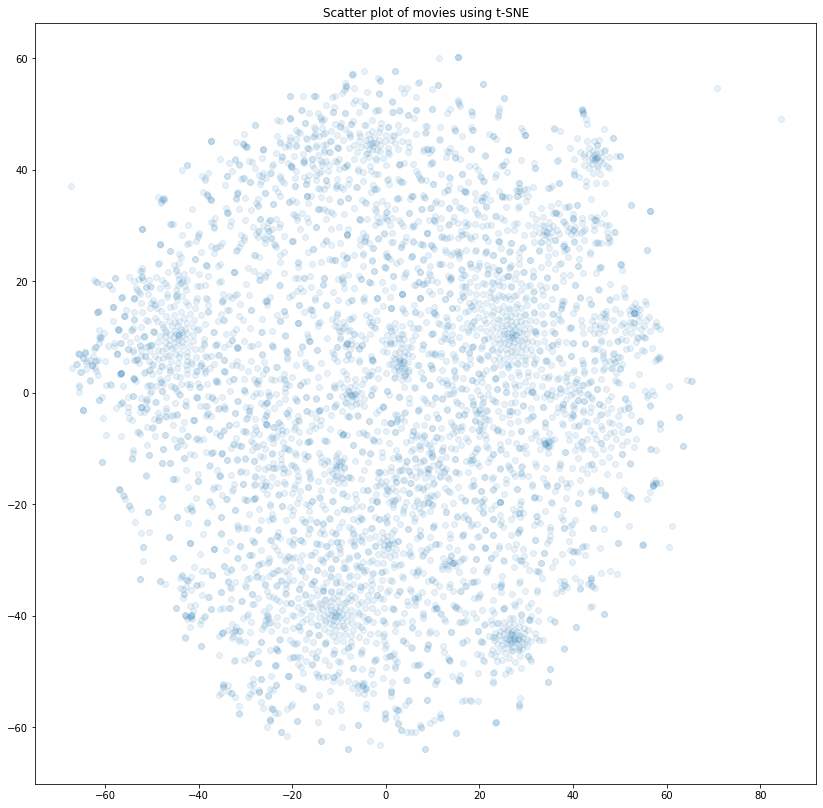

In [165]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, n_iter=1000, metric="cosine")

#次に、埋め込みマトリックスで fit andtransform を呼び出します。
embs = tsne.fit_transform(count_matrix)

# データフレームに追加
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

#散布図作成
plt.figure(figsize=(14, 14))
plt.scatter(embs[:, 0], embs[:, 1], alpha=.1)
plt.title('Scatter plot of movies using t-SNE')
plt.show()

In [166]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """与えられた x と y の限界で囲まれた写像空間の領域をプロットします。 """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """指定されたタイトルで映画の近くのマッピングスペースの領域をプロットします。marginパラメータは、映画の周りの近傍のサイズを制御します。"""
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]

    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)



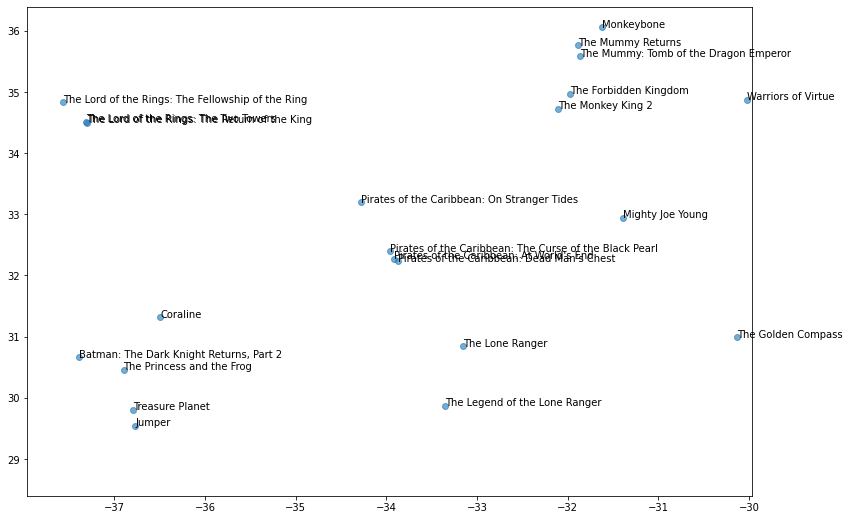

In [167]:
# 指定の映画の近傍(±4)の映画を可視化します
plot_region_around('Pirates of the Caribbean: The Curse of the Black Pearl',4)
plt.show()

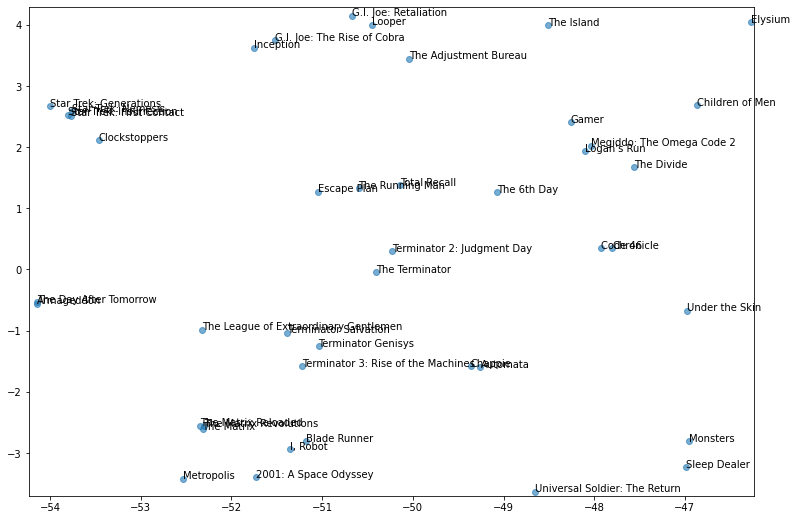

In [168]:
# 指定の映画の近傍(±4)の映画を可視化します
plot_region_around('Terminator 2: Judgment Day',4)
plt.show()

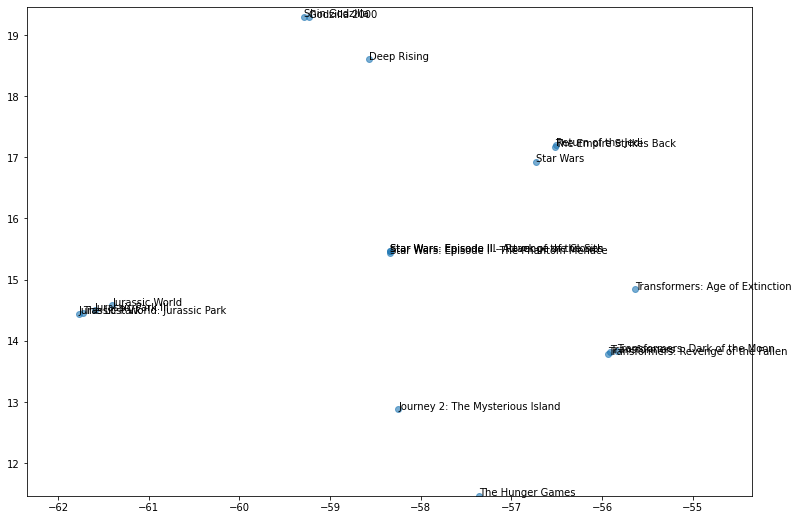

In [173]:
# 指定の映画の近傍(±4)の映画を可視化します
plot_region_around('Star Wars: Episode III - Revenge of the Sith', 4)
plt.show()